# Обработка датасета русского рэпа

Скачав архив с собранными json - файлами, несущих информацию о треках, первым делом пришлось приводить в читабельный вид. Так как кодировка и у названий файлов и их содержимого была maccyrillic. И всю кириллицу ни средства маздая, ни pycharm не могли воспроизвести.

# 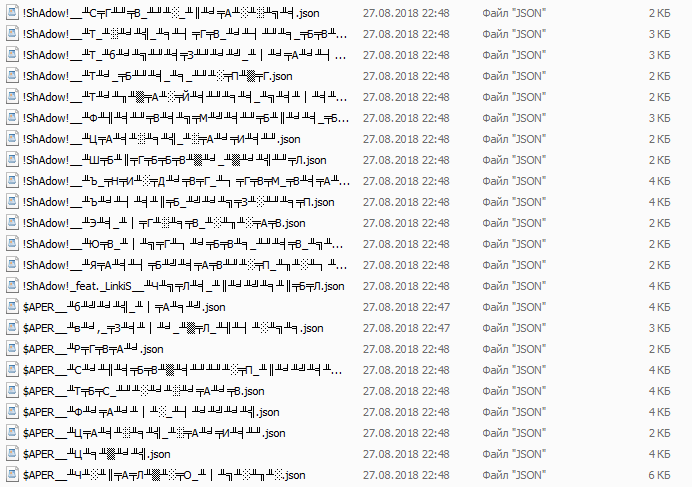

После осмотра контента было замечено, что многие артисты повторяются в силу разного написания их имени (например "1kla$", "1 kla$", "1кла$", несколько вариантов витикаки47 и т.п.). Таким образом, необходимо найти все треки, что принадлежат одному исполнителю. 

Плюсом ко всему этому имеет место быть совместные записи нескольких исполнителей. Присвоить трек первому как-то неправильно, а учитывать их как отдельный коллектив в общей картине будет как-то странно (в большинстве случаев у них всего один трек). Поэтому отбрасываем все треки, что имеют в имени исполнителя feat. или где через запятую перечислены рэперы.

Чтоб достигнуть поставленной цели, приводим имя исполнителя к "некоторому каноничному виду". Все буквы - мелкие, пробелы убираем, транслитерацией переводим имя в русские буквы, и после всего этого ещё находим расстояние Левенштейна между словами и если оно меньше 3-х, то будем принимать исполнителя за одного.

Все необходимое для функций, что потребуются еще много раз:

In [18]:
import string
import json
import os
from glob import glob
import re
from transliterate import translit
import urllib.parse

FLAG_ABOUT_REPEAT = 'hvjkbvjkjkbjkerk'

patternFeat = re.compile(".* ?feat ?.*")
patternFeat2 = re.compile(".+[,&] ?.+")
artists = set()

In [5]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

In [6]:
def normilizeArtist(str):
    return translit(re.sub('\(.*\)', '', str).lower().replace(' ', ''), "ru")

Функция, которая в указанной папке среди треков будет искать уникальных исполнителей:

In [7]:
def findUniqueName(dirpath):
    for path in glob(os.path.join(os.path.expanduser(dirpath), '*.json')):
        file = open(path, mode="r", encoding="maccyrillic")
        data = json.load(file)
        artist = urllib.parse.unquote(data["artist"]).encode('maccyrillic').decode('utf-8')
        if not (bool(patternFeat.match(artist)) or bool(patternFeat2.match(artist))):
            artists.add(artist)

    artList = list(sorted(artists))

    for i in range(0, len(artList) - 1):
        for j in range(i + 1, len(artList)):
            if levenshtein(normilizeArtist(artList[i]), normilizeArtist(artList[j])) < 3:
                artList[j] = FLAG_ABOUT_REPEAT

    return list(set(artList) - set([FLAG_ABOUT_REPEAT]))

Перечень всех имеющихся:

In [9]:
print(sorted(findUniqueName("./songs")))

['!ShAdow!', '$APER', '1 Kla$', '1000 y.e.', '1000 Слов', '13FRONT', '228', '2H Company', '3NT', "4'K", '43 Градуса', '4пыль', '5 Плюх', '56 размер', '6-ой отряд и Главные Герои', '63 Регион', '9 Грамм', 'AK-47', 'AL Hammer', 'Ahimas', 'Al Solo', 'AlexJackpot', 'Amlaut', 'Anacondaz', 'Ar-SiDE', 'Axxy', 'AzonE', 'Aztecs', 'B-Laba', 'B-Noble', 'B.b. [TERRA INCOGNITA]', 'Babangida', 'Bad Game', 'Bahh Tee', 'Basic', 'Beat Of Life', 'Beny Krik', 'Bess', 'Big Black Boots', 'BrainDraiN', 'Buhar Jerreau', 'C-Pack', 'C4', 'CENTR', 'Check', 'Chooze', 'Counter Attack', 'CуиСайд', "D'ARTY", 'D-MAN 55', 'D.A.P.A.', 'D.L.S', 'D.Masta', 'D1MASS', 'DANDY', 'DIUv[Kadastra_pro]', 'DOm1no (FreshTime)', 'DRedd', 'Da 108', 'Da B.O.M.B.', 'Da Gudda Jazz', 'Da Gudda Prod.', 'Da St', 'De F. (Дефицит)', 'De Facto', 'DeShawn a.k.a. Je', 'Dead Poets', 'Dessar', 'Dime', 'Dinastia S. L.', 'Dino MC 47', 'Djang', 'DoN-A', 'Dobermann', 'Dogma KZ', 'DotsFam', 'Double Magnum', 'DragN', 'Dza-Dze', 'Dzham', "DИ'АСПОРА", 

Дальше необходимо провести препроцессинг текстов:

In [20]:
from nltk import SnowballStemmer
from nltk.corpus import stopwords

def text_stemming(raw_text, wordDict = None):
  clean_text = []
  raw_text=raw_text.replace('\t', ' ').replace('\n', ' ').replace('\r', '').replace('–', '')
    
  for punctuation in string.punctuation:
    raw_text = raw_text.replace(punctuation, ' ')
    
  raw_text = raw_text.split()
  stemmer = SnowballStemmer("russian")
  for word in raw_text:
    word_low = word.lower()
    if word_low not in stopwords.words('russian') and not word.isdigit():
        if wordDict is not None:
            if word_low in wordDict:
                clean_text.append(stemmer.stem(word_low))
        else:
            clean_text.append(stemmer.stem(word_low))

  clean_text = ' '.join(clean_text)
  return clean_text

Т.к. вновь будем пробегать по json файлам, где указаны первоначальные имена, то для определения к какому исполнителю относится песня, используем данную функцию:

In [12]:
def findArtistsKey(str):
    for item in docCollection.keys():
        if un.levenshtein(un.normilizeArtist(str), un.normilizeArtist(item)) < 3:
            return item
    return None

Подготавливаем словарь для текстов

In [14]:
DIR_PATH = ".\\songs"
docCollection = dict()
for item in findUniqueName(DIR_PATH):
    docCollection[item] = list()
docCollection

{'Eighty Eight': [],
 'Шахматист': [],
 'ХОРОрШОу': [],
 'Интервенция': [],
 'Убитые рэпом': [],
 'Da Gudda Prod.': [],
 'Slow Flow': [],
 'Dobermann': [],
 'Ганза': [],
 'Макс Винтер': [],
 'Крип-А-Крип (Крипл)': [],
 'DotsFam': [],
 'Паша Морган': [],
 'Чаян Famaly': [],
 'Театр Теней': [],
 'Риару': [],
 'Дядя Женя': [],
 'Фаддей': [],
 'Hann': [],
 'Ahimas': [],
 'Бурый': [],
 'KimBusta': [],
 'Плохие Белые': [],
 'The ЛП (Ленина Пакет)': [],
 'MC 1.8': [],
 'D-MAN 55': [],
 'DragN': [],
 'Beat Of Life': [],
 'Bess': [],
 'MaryJane': [],
 'T-killah': [],
 '56 размер': [],
 'Lenin': [],
 'Kurbat': [],
 'Miss Fenix': [],
 'EK-Playaz': [],
 'Dinastia S. L.': [],
 "Lil'M": [],
 'Raphael': [],
 'Mr. Hyde': [],
 'Капа и Картель': [],
 'Aztecs': [],
 'Little B.': [],
 'Da St': [],
 'Kore': [],
 'DoN-A': [],
 'Dzham': [],
 'Franky Freak': [],
 'LegMc': [],
 '228': [],
 'Витяй Счастье': [],
 'MC Den': [],
 "N'Pans": [],
 'Kozz Porno': [],
 'T1One a.k.a. Коля Сканк': [],
 'Kiraz': [],
 'Ниль

Заполняем структуру текстами и сохраняем в папку "textsByArtist" json файлы с предобработанными текстами исполнителей

In [ ]:
for path in glob(os.path.join(os.path.expanduser(DIR_PATH), '*.json')):
    file = open(path, mode="r", encoding="maccyrillic")
    data = json.load(file)
    artist = un.normilizeArtist(urllib.parse.unquote(data["artist"]).encode('maccyrillic').decode('utf-8'))

    keyArtist = findArtistsKey(artist)
    if keyArtist is not None:
        text = text_stemming(urllib.parse.unquote(' '.join(data['text'])).encode('maccyrillic').decode('utf-8', errors="ignore"))
        docCollection[keyArtist].append(text)

for key in docCollection.keys():
    with open('.\\textsByArtist\\' + key.replace(' ', '_') + '.json', 'w', encoding='utf-8') as outfile:
        json.dump({"artist": key, "texts": docCollection[key]}, outfile, ensure_ascii=False)

Итого 444 исполнителя

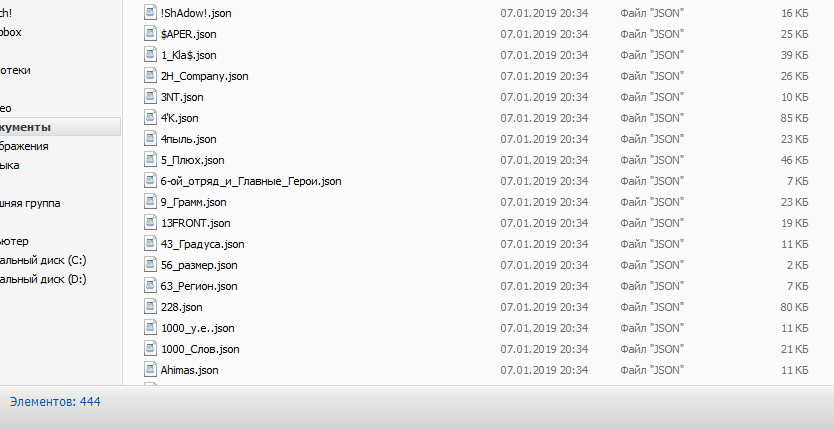

Дальше необходимо для кажого исполнителя найти ТОП 1000 используемых слов.
Реализовываем типовую задачу на MapReduce:

In [ ]:
import sys
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
import operator
import re

WORD_RE = re.compile(r"[A-Za-zА-Яа-я]+")

class MRWordFreqCount(MRJob):
    OUTPUT_PROTOCOL = ReprProtocol

    def mapper(self, _, line):
        for word in WORD_RE.findall(line):
            yield word.lower(), 1

    def combiner(self, word, counts):
        yield word, sum(counts)

    def reducer(self, word, counts):
        yield word, str(sum(counts))

if __name__ == '__main__':
    worker = MRWordFreqCount()
    worker.sandbox(open(sys.argv[1], 'rb'))

    result = dict()

    with worker.make_runner() as runner:
        runner.run()
        for key, value in worker.parse_output(runner.cat_output()):
            if len(key) > 2:
                result[key] = int(value)

        result.pop('artist', None)
        result.pop('texts', None)
        countRows = 0
        with open(sys.argv[2], 'w') as f:
            for item in sorted(result.items(), key=operator.itemgetter(1), reverse=True):
                if countRows < 1000:
                    f.write(item[0] + " " + str(item[1]) + "\n")
                    countRows += 1

А дальше, запускаем .bat - файл со следующим содержанием:

In [ ]:
if not exist ".\sortWordFreq" mkdir .\sortWordFreq
for %%f in (.\textsByArtist\*) do python freq_words.py %%f .\sortWordFreq\%%~nf

В итоге получим папку .\sortWordFreq с топ-1000 для каждого исполнителя

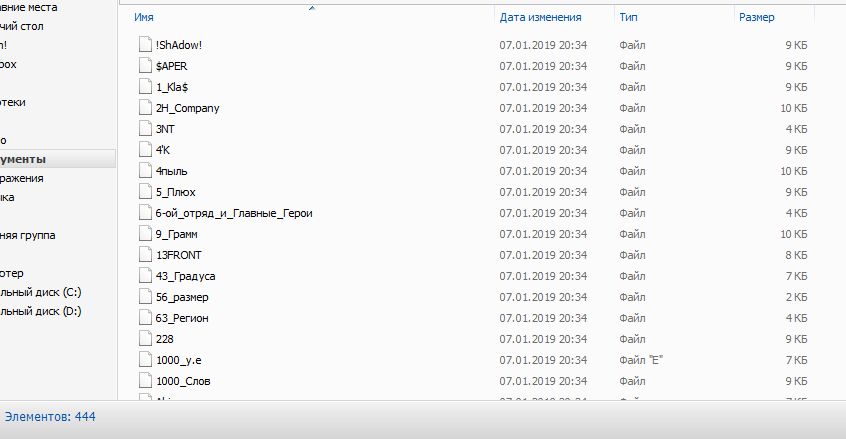

Теперь имея данные, визуализируем как близко друг к другу находятся исполнители относительно исполняемого контента

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.manifold import MDS

MDS()

DIR_PATH_TEXTS = ".\\textsByArtist"
DIR_PATH_WORDS = ".\\sortWordFreq"

textArtist = dict()


def getWordSet(filename):
    result = set()
    file = open(DIR_PATH_WORDS + "\\" + filename)
    for line in file:
        result.add(line.split(" ")[0])
    return result

D:\Distrib\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
D:\Distrib\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


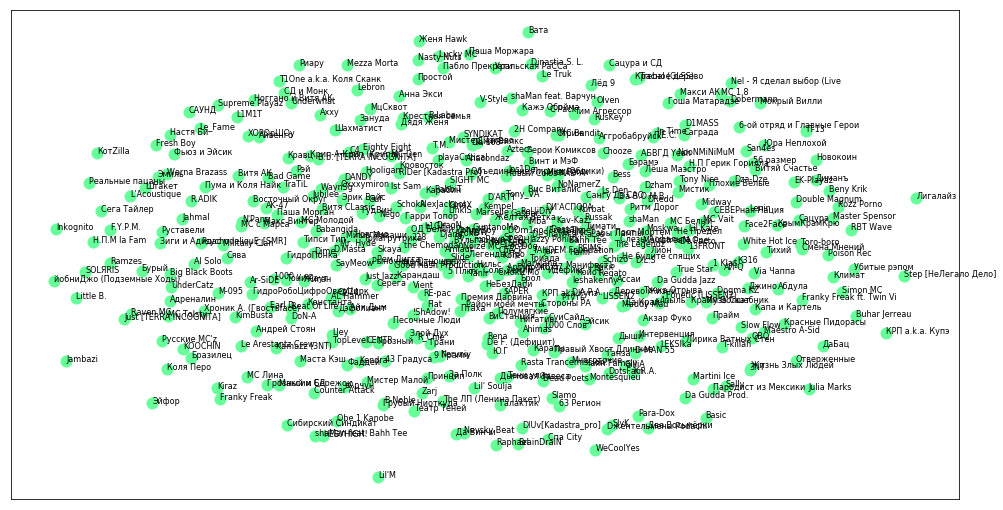

In [23]:
for path in glob(os.path.join(os.path.expanduser(DIR_PATH_TEXTS), '*.json')):
    nameFile = os.path.basename(path)[:os.path.basename(path).rfind('.')]  # without extension
    file = open(path, mode="r", encoding="maccyrillic")
    data = json.load(file)
    artist = urllib.parse.unquote(data["artist"]).encode('maccyrillic').decode('utf-8')
    wordSet = getWordSet(nameFile)

    texts = list()
    for text in data['texts']:
        texts.append(text_stemming(urllib.parse.unquote(text).encode('maccyrillic').decode('utf-8', errors="ignore"),
                                   wordDict=wordSet))
    textArtist[artist] = " ".join(texts)

listArt = np.array(list(textArtist.items()))
print(listArt)

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                   min_df=0.1,
                                   use_idf=True, ngram_range=(1, 1))

tfidf_matrix = tfidf_vectorizer.fit_transform(listArt[:, 1])
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print(terms)
dist = 1 - cosine_similarity(tfidf_matrix)
print(dist)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
print(xs)
print(ys)

df = pd.DataFrame(dict(x=xs, y=ys, name=listArt[:, 0]))

df.to_csv("results.csv", sep='\t', encoding='utf-8')

fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)

for index, row in df.iterrows():
    ax.plot(row['x'], row['y'], marker='o', linestyle='', ms=12, color='#66ff99', mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')

for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['name'], size=8)

plt.show()

Теперь проведем LDA-анализ для всего корпуса русского рэпа. Для этого все тексты смержим в один файл.

In [ ]:
texts = list()
DIR_PATH_TEXTS = ".\\songs"

countTexts = 0

for path in glob(os.path.join(os.path.expanduser(DIR_PATH_TEXTS), '*.json')):
    file = open(path, mode="r", encoding="maccyrillic")
    data = json.load(file)
    text = text_stemming(
        urllib.parse.unquote(' '.join(data['text'])).encode('maccyrillic').decode('utf-8', errors="ignore"))
    texts.append(text.split())
    countTexts += 1
    if countTexts % 1 == 0:
        print("Complete: " + str(countTexts))

with open('for_lda.json', 'w', encoding='utf-8') as filehandle:
    json.dump(texts, filehandle, ensure_ascii=False)

In [ ]:
from gensim import corpora, models, similarities

with open('for_lda.json', 'r', encoding='utf-8') as file:
    texts = json.load(file)

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.7)
corpus = [dictionary.doc2bow(text) for text in texts]

lda = models.LdaModel(corpus, num_topics=10,
                      id2word=dictionary,
                      update_every=3,
                      chunksize=5000,
                      passes=100)

lda.show_topics()

topics_matrix = lda.show_topics(formatted=False, num_words=20)
print("Topics:")
for item in topics_matrix:
    print(item)

После полутора часов вычислений, получила следующие результаты:

In [ ]:
Topics:
(0,
 [('жизн', 0.007569376), ('сво', 0.006806156), ('мир', 0.0060578203), ('люд', 0.0059849625), ('вер', 0.0058179046),
  ('наш', 0.0042834077), ('кажд', 0.004246467), ('пок', 0.0038917342), ('все', 0.00387356), ('сил', 0.003390165),
  ('бог', 0.0033693174), ('нам', 0.0031815032), ('стал', 0.0031753213), ('свет', 0.0031492333),
  ('брат', 0.0029872076), ('пут', 0.0029515475), ('рук', 0.0028291084), ('одн', 0.0028127462),
  ('глаз', 0.002788241), ('душ', 0.0027598834)])
(1, [('че', 0.016046572), ('i', 0.010510571), ('yo', 0.0078255255), ('the', 0.006536205), ('a', 0.0061505055),
     ('on', 0.0049407114), ('дава', 0.004653976), ('э', 0.0043100915), ('my', 0.004097153), ('me', 0.004057307),
     ('it', 0.0038767348), ('and', 0.0036471877), ('говор', 0.0036002144), ('to', 0.003565932), ('s', 0.0034318552),
     ('m', 0.0033739947), ('ху', 0.0031222678), ('is', 0.0029849822), ('in', 0.0027481962), ('ид', 0.0027099175)])
(2, [('тво', 0.012271334), ('все', 0.010460019), ('прост', 0.010247782), ('мо', 0.009249248), ('теб', 0.0075250743),
     ('глаз', 0.0062158415), ('тоб', 0.005926064), ('буд', 0.0058406373), ('зна', 0.005617251),
     ('одн', 0.0055989777), ('сво', 0.0055766203), ('жизн', 0.0053042867), ('сердц', 0.0051787044),
     ('друг', 0.0051345457), ('лиш', 0.0047756704), ('люб', 0.0046680206), ('ноч', 0.0046352306),
     ('слов', 0.004559042), ('нам', 0.0045412625), ('любов', 0.0043149334)])
(3, [('мо', 0.009818013), ('рэп', 0.00849791), ('все', 0.008285733), ('слов', 0.0046530548), ('пок', 0.004291819),
     ('нам', 0.004188155), ('прост', 0.0040306947), ('ещ', 0.0038254077), ('сво', 0.003768059),
     ('буд', 0.003716336), ('жизн', 0.0037093356), ('песн', 0.0034829006), ('наш', 0.0032918511),
     ('кажд', 0.003175574), ('так', 0.0031666828), ('ваш', 0.0030745266), ('музык', 0.0030394709),
     ('люд', 0.00282136), ('перв', 0.0027565693), ('сам', 0.002753199)])
(4,
 [('дела', 0.012998416), ('наш', 0.00737576), ('сво', 0.0062531857), ('кажд', 0.005656418), ('дава', 0.005136786),
  ('нам', 0.0050817993), ('двига', 0.004902778), ('всем', 0.004784577), ('танц', 0.004295346), ('бит', 0.004224436),
  ('кача', 0.0038990478), ('ак', 0.003734639), ('э', 0.003411792), ('рэп', 0.0033284705), ('ваш', 0.0030877197),
  ('пок', 0.0030299681), ('голов', 0.0028115255), ('тем', 0.0026174474), ('клуб', 0.0025396813),
  ('выш', 0.0025314004)])
(5, [('волн', 0.0066411295), ('им', 0.005699862), ('город', 0.00547547), ('привет', 0.004935737),
     ('паца', 0.004689538), ('ввид', 0.0045570075), ('наш', 0.0044905776), ('ак', 0.003984469),
     ('дом', 0.0032997057), ('мод', 0.0032075294), ('ро', 0.0031478025), ('стенк', 0.0031333484),
     ('ват', 0.0023620524), ('трит', 0.0023339055), ('лял', 0.0021042507), ('поня', 0.0019580326),
     ('солнц', 0.0019026482), ('куб', 0.0017816088), ('чемода', 0.0017237044), ('шаг', 0.0016819149)])
(6,
 [('хоп', 0.010514767), ('хип', 0.010282907), ('рэп', 0.0057334406), ('любл', 0.005031193), ('люб', 0.0046099564),
  ('город', 0.0036879058), ('ногга', 0.0031546715), ('клуб', 0.0029306023), ('бит', 0.0028293012),
  ('москв', 0.0028071855), ('крут', 0.0027908785), ('крич', 0.0027231604), ('тво', 0.0025644551),
  ('наш', 0.0025466473), ('дава', 0.0025267547), ('стил', 0.002500509), ('go', 0.002491202), ('сам', 0.0023811597),
  ('ваш', 0.0023307311), ('мно', 0.0020927743)])
(7, [('дом', 0.0063220104), ('мо', 0.00594932), ('так', 0.004535566), ('че', 0.0044897), ('нам', 0.0043744356),
     ('район', 0.004060315), ('дел', 0.0037398015), ('пар', 0.003549353), ('кур', 0.0033047262),
     ('дава', 0.0032642994), ('сво', 0.002909181), ('утр', 0.0029073337), ('все', 0.0028744193),
     ('мам', 0.0028477663), ('паца', 0.002793178), ('помн', 0.0027703983), ('москв', 0.0027305789),
     ('наш', 0.0026055158), ('рук', 0.0024227584), ('одн', 0.0024190333)])
(8,
 [('тво', 0.01692999), ('теб', 0.009351816), ('рэп', 0.007350007), ('баттл', 0.0045784838), ('пар', 0.0039088624),
  ('сук', 0.0038567258), ('трек', 0.003719616), ('ваш', 0.0032790354), ('буд', 0.0031615451),
  ('парен', 0.0030902743), ('прост', 0.0029534495), ('е', 0.0028721197), ('мо', 0.002848247), ('сво', 0.0027473432),
  ('нужн', 0.002636237), ('дела', 0.0024973573), ('перв', 0.0024064395), ('так', 0.0023552983),
  ('пок', 0.0023094139), ('раунд', 0.0022668224)])
(9, [('рэп', 0.0161417), ('тво', 0.015193637), ('сво', 0.0081357425), ('мо', 0.0064990795), ('ваш', 0.0051548895),
     ('сук', 0.00505446), ('теб', 0.0050508855), ('люб', 0.004474324), ('говор', 0.004439613),
     ('прост', 0.003975548), ('ху', 0.003695244), ('нах', 0.0035016106), ('чита', 0.003495981),
     ('дела', 0.0034210547), ('пох', 0.0034104201), ('русск', 0.003341228), ('зна', 0.0033246563),
     ('так', 0.0033209021), ('че', 0.0032139292), ('всем', 0.0031731024)])